<a href="https://colab.research.google.com/github/Rahma-Alam-Samiha/Time-Series-Analysis-of-Air-Passengers-Data-SNS-Flights-dataset/blob/main/Time_Series_Analysis_of_Air_Passengers_Data_from_SNS_Flights_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING OF LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as  sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import ar_select_order

from sklearn.metrics import mean_squared_error

LOADING AIR PASSEENGER DATASET

In [2]:
data=sns.load_dataset('flights')

EXPLORING THE DATA

In [3]:
data.head(5) #DISPLAYING DATA

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


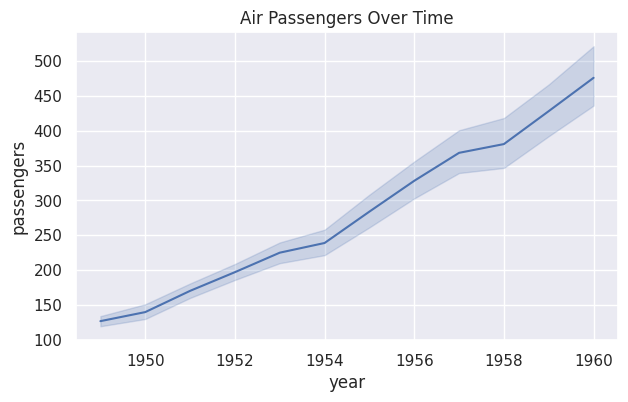

In [4]:
#PLOTING TIME SERIES

sns.set(rc={'figure.figsize': (7,4)})
sns.lineplot(x='year', y='passengers', data=data)
plt.title('Air Passengers Over Time')
plt.show()

DATA PROCESSING

In [5]:
#CONVERTING DATA INTO TIME SERIES
data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month'].astype(str))
ts_data = data.set_index('date')['passengers']

In [6]:
#CHECKING MISSING VALUES
ts_data.isnull().sum()

0

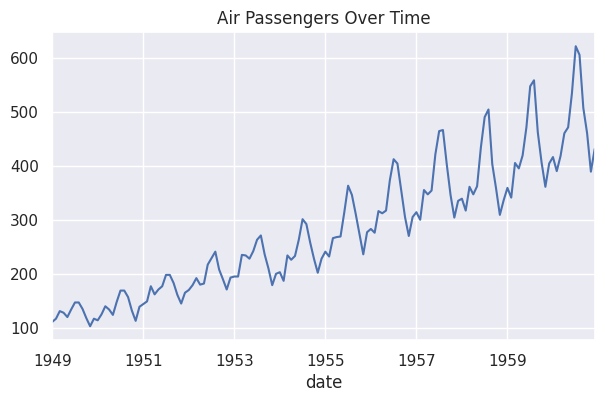

In [7]:
# Plot the time series data
ts_data.plot()
plt.title('Air Passengers Over Time')
plt.show()

In [8]:
ts_data.head(5)

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: passengers, dtype: int64

TIME SERIES DECOMPOSITION

In [9]:
# Decompose the time series into trend, seasonality, and residual components
decomposition = seasonal_decompose(ts_data, model='multiplicative', period=12)

In [10]:
# Plot the decomposed components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

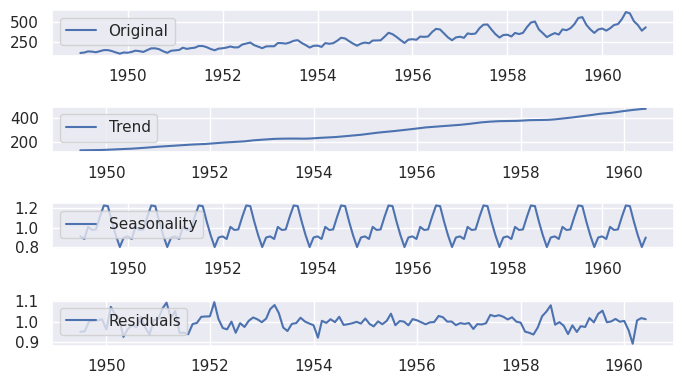

In [11]:
plt.subplot(411)
plt.plot(ts_data, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

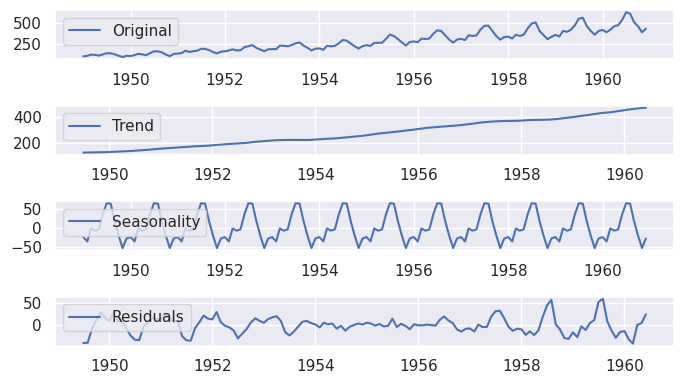

In [12]:
# Additive decomposition
decomposed = seasonal_decompose(ts_data, model="additive", period=12)

# Plot the decomposed components
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

plt.subplot(411)
plt.plot(ts_data, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

STATIONARITY CHECK

In [13]:
# Check for stationarity using the Augmented Dickey-Fuller test
result = adfuller(ts_data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# If p-value > 0.05, the series is non-stationary. We can apply differencing.

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


MODEL SELECTION TRAINING

In [14]:
# Differencing to make the series stationary
ts_data_diff = ts_data.diff().dropna()

# Fit an ARIMA model
model = ARIMA(ts_data_diff, order=(1, 1, 1))
results = model.fit()

# Display the model summary
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -696.464
Date:                Thu, 07 Mar 2024   AIC                           1398.929
Time:                        18:46:45   BIC                           1407.796
Sample:                    02-01-1949   HQIC                          1402.532
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3129      0.100      3.128      0.002       0.117       0.509
ma.L1         -0.9997      3.155     -0.317      0.751      -7.184       5.184
sigma2      1034.0623   3302.525      0.313      0.7

MODEL EVALUATION AND FORECASTING

In [15]:
ts_data.head(3)

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
Name: passengers, dtype: int64

In [16]:
data_dict = {"date": ts_data.index, "passengers": ts_data.values}
df = pd.DataFrame(data_dict)
df = df.set_index("date")
df

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [17]:
from prophet import Prophet

# Prepare data for Prophet
df_prophet = pd.DataFrame(dict(ds=df.index, y=df["passengers"]))

# Fit the Prophet model
model = Prophet()
model.fit(df_prophet)

# Forecast future values
future = model.make_future_dataframe(periods=12)
forecast = model.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj5d4v3d7/igy2d1ad.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj5d4v3d7/t_1ttjcr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38501', 'data', 'file=/tmp/tmpj5d4v3d7/igy2d1ad.json', 'init=/tmp/tmpj5d4v3d7/t_1ttjcr.json', 'output', 'file=/tmp/tmpj5d4v3d7/prophet_modelb8kgss0q/prophet_model-20240307184646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [18]:
# Compare Actual and Predicted Values
actual_values = df_prophet['y'][-12:]
predicted_values = forecast['yhat'].tail(12)

In [19]:
# Calculate Mean Absolute Percentage Error (MAPE) with robust handling
mape_sum = 0
count = 0

for actual, predicted in zip(actual_values, predicted_values):
    if actual != 0:
        mape_sum += np.abs((actual - predicted) / actual)
        count += 1

mape = (mape_sum / count) * 100 if count != 0 else np.nan



rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

print('Mean Absolute Percentage Error (MAPE): {:.2f}%'.format(mape))
print('Root Mean Squared Error (RMSE): {:.2f}'.format(rmse))

Mean Absolute Percentage Error (MAPE): 14.16%
Root Mean Squared Error (RMSE): 97.67


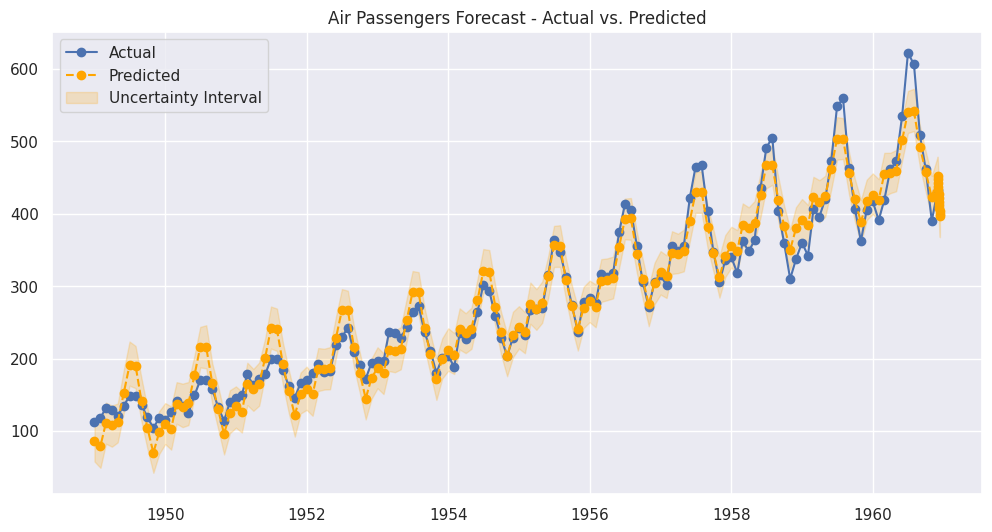

In [20]:
# Visualize Actual vs. Predicted Values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, df['passengers'], label='Actual', marker='o')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted', linestyle='--', color='orange', marker='o')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label='Uncertainty Interval')
ax.legend()
ax.set_title('Air Passengers Forecast - Actual vs. Predicted')
plt.show()

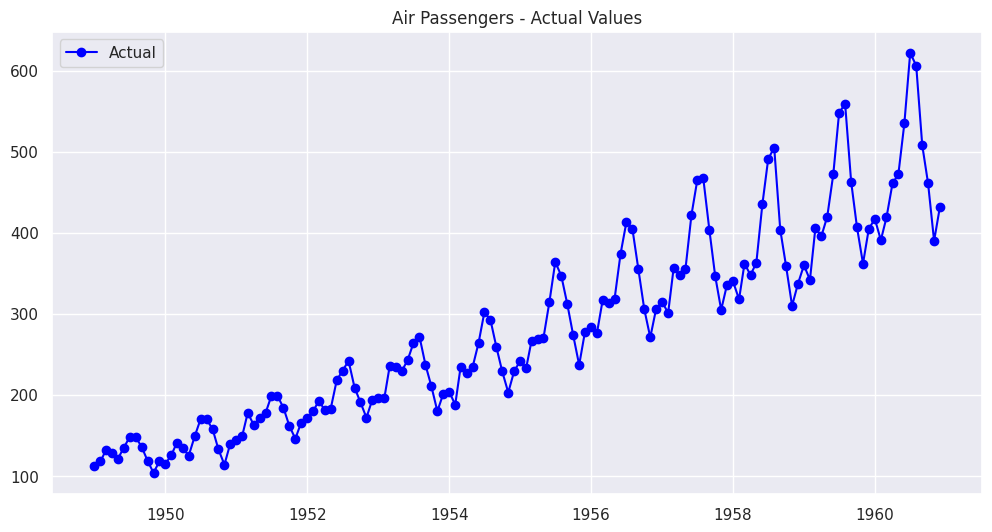

In [21]:
# Visualize Actual Values
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df.index, df['passengers'], label='Actual', marker='o', color='blue')
ax1.legend()
ax1.set_title('Air Passengers - Actual Values')
plt.show()

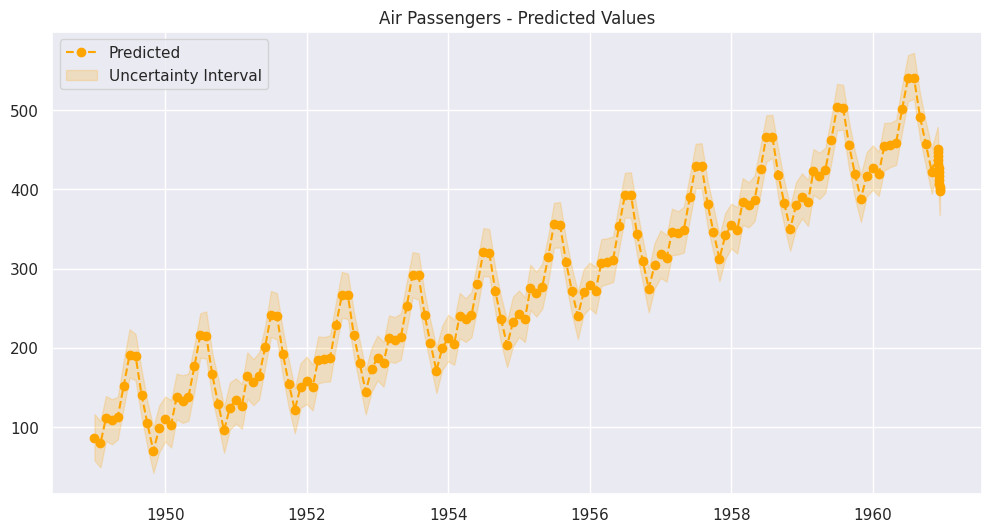

In [22]:
# Visualize Predicted Values
fig, ax2 = plt.subplots(figsize=(12, 6))
ax2.plot(forecast['ds'], forecast['yhat'], label='Predicted', linestyle='--', color='orange', marker='o')
ax2.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label='Uncertainty Interval')
ax2.legend()
ax2.set_title('Air Passengers - Predicted Values')

plt.show()

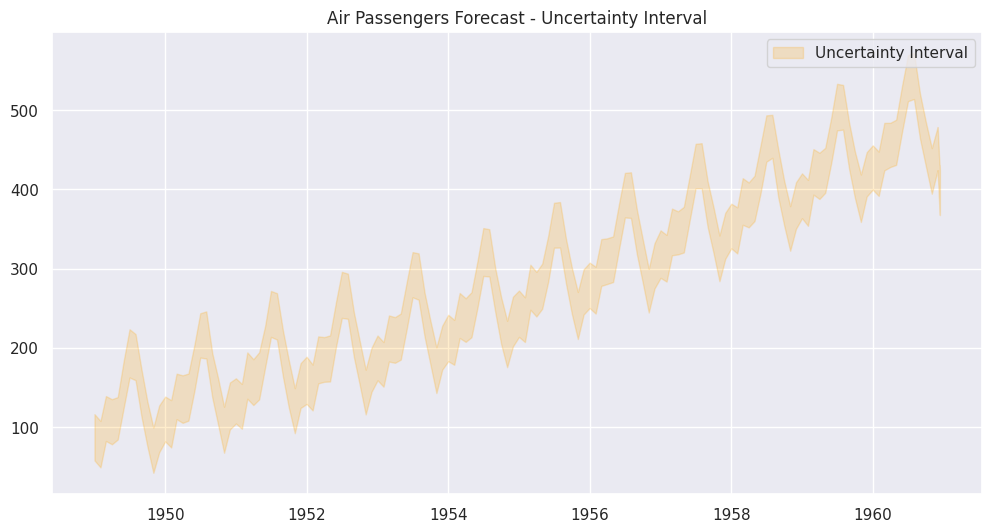

In [23]:
# Visualize Uncertainty Interval
fig, ax = plt.subplots(figsize=(12, 6))
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label='Uncertainty Interval')
ax.legend()
ax.set_title('Air Passengers Forecast - Uncertainty Interval')
plt.show()


MODEL EVALUATION

In [24]:
# Analyze and Interpret Results

# Print the analysis and interpretation of results
print("Analysis and Interpretation:")
print("1. The Mean Absolute Percentage Error (MAPE) is {:.2f}%.".format(mape))
print("2. The Root Mean Squared Error (RMSE) is {:.2f}.".format(rmse))
print("3. Visual inspection of the plot shows how well the forecast aligns with the actual airline passenger numbers.")
print("4. Pay attention to any patterns or discrepancies between actual and predicted values.")
print("5. Consider refining the model or exploring additional features for more accurate predictions.")

Analysis and Interpretation:
1. The Mean Absolute Percentage Error (MAPE) is 14.16%.
2. The Root Mean Squared Error (RMSE) is 97.67.
3. Visual inspection of the plot shows how well the forecast aligns with the actual airline passenger numbers.
4. Pay attention to any patterns or discrepancies between actual and predicted values.
5. Consider refining the model or exploring additional features for more accurate predictions.


In summary, the model has a MAPE of 14.16%, indicating a reasonably low average percentage error in predictions, and an RMSE of 97.67, suggesting that, on average, the model's predictions deviate by around 97.67 units from the actual values.